# Project

* Peyman Naseri, `96100522`
* Mobina Pournemat, `97105833`
* 
*
*

# setting gpu

for use local gpu run this comand in anaconda prompet and copy url and paste on colab:

    pip install jupyter_http_over_ws
    jupyter serverextension enable --py jupyter_http_over_ws
    jupyter notebook --NotebookApp.allow_origin='https://colab.research.google.com' --port=8888 --NotebookApp.port_retries=0

https://research.google.com/colaboratory/local-runtimes.html  


In [ ]:
import torch
# setting device on GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')

Using device: cuda

NVIDIA GeForce RTX 2080 with Max-Q Design
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


In [ ]:
# import tensorflow as tf
# gpus = tf.config.experimental.list_physical_devices('GPU')
# if gpus:
#   try:
#     for gpu in gpus:
#       tf.config.experimental.set_memory_growth(gpu, True)
#       # tf.config.experimental.set_virtual_device_configuration(gpu,
#       #                                                         [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024*6)])

#   except RuntimeError as e:
#     print(e)


# if len(tf.config.list_physical_devices('GPU')) > 0:
#   !nvidia-smi --query-gpu=gpu_name,driver_version,memory.total --format=csv

## gpu monitoring

In [ ]:
! pip install transformers datasets accelerate nvidia-ml-py3

In [ ]:
from pynvml import *


def print_gpu_utilization():
    nvmlInit()
    handle = nvmlDeviceGetHandleByIndex(0)
    info = nvmlDeviceGetMemoryInfo(handle)
    print(f"GPU memory occupied: {info.used//1024**2} MB.")


def print_summary(result):
    print(f"Time: {result.metrics['train_runtime']:.2f}")
    print(f"Samples/second: {result.metrics['train_samples_per_second']:.2f}")
    print_gpu_utilization()

In [ ]:
torch.cuda.empty_cache()
import gc
# del variables
gc.collect()

10

In [ ]:
print_gpu_utilization()

GPU memory occupied: 218 MB.


# requirement package

In [ ]:
%%capture
# !pip install Levenshtein
# !pip install transformers
# !pip install hazm

In [ ]:
from torch.nn import functional as F
import torch
import Levenshtein
import re
from hazm import *

In [ ]:
import os
import numpy as np
import pandas as pd 
# from pandas_profiling import ProfileReport

import matplotlib.pyplot as plt
import seaborn as sns               
%matplotlib inline
sns.set()
plt.style.use("ggplot")

import warnings                                            
warnings.filterwarnings('ignore')

In [ ]:
import sys

# DATA

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
# %cd /content/drive/MyDrive/NLP/HW3/NLP-HW3-Resources/

import zipfile

datasets = ["cultural.zip", "economics.zip", "politics.zip", "sports.zip"]
data = []


for dataset in datasets:
    with zipfile.ZipFile(dataset) as zipper:
        with zipper.open(dataset.split(".")[0]+'.txt') as fp:
            d = fp.read().decode('utf-8').split('\n')
            data += d #:len(d)//16



# %cd /content/drive/MyDrive/NLP/HW3/

**Manipulating the data according to the required Input formatting**

The input format required by BERT asks us to add special tokens to the start and end of the sentence, pad and truncate all the sentences to a specific constant length and differentiate the pads from tokens by using attention masks.

To get an idea about the length of the description and its corresponding frequency

As we have to explicitly pad and truncate all the sentences to a fixed constant length, visualisation of the text length of the cleaned and pre processed data is done in order to select a value that is as close to the actual value (so that we do not lose useful information)

In [ ]:
seq_len = [len(i.split()) for i in data]

[(0.0, 500.0)]

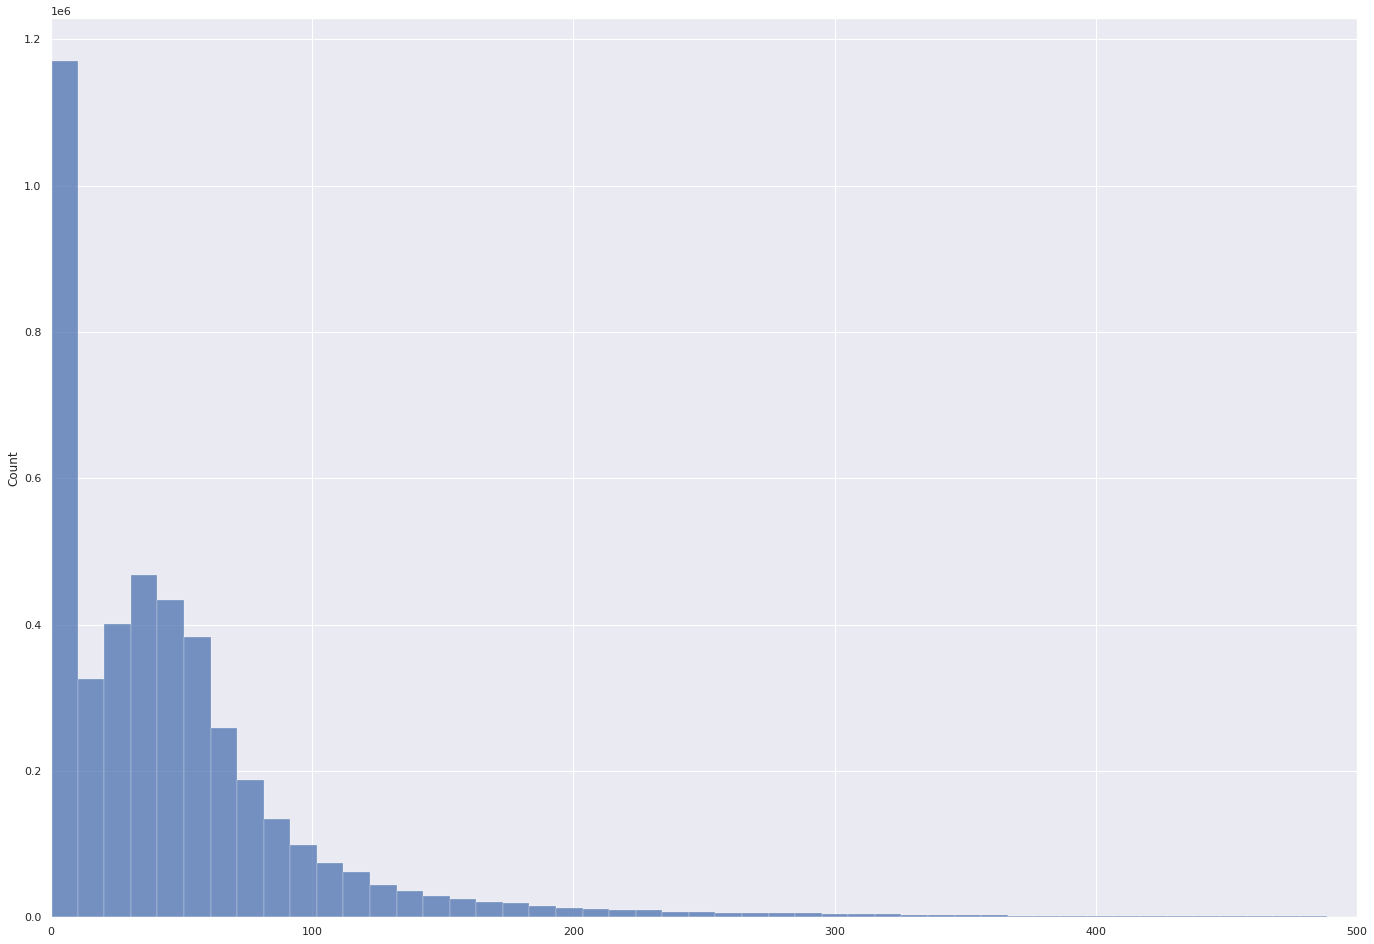

In [ ]:
sns.set(rc={'figure.figsize':(11.7*2,8.27*2)})
his_plot = sns.histplot(seq_len ,bins=500 )
his_plot.set(xlim=(0,500))

In [ ]:
df_len  = pd.DataFrame(seq_len, columns=['length'])
df_len

,length
0,130
1,5
2,9
3,132
4,353
...,...
4331680,45
4331681,75
4331682,35
4331683,0


In [ ]:
df_len.describe()

,length
count,4.331685e+06
mean,5.115670e+01
std,7.158993e+01
min,0.000000e+00
25%,9.000000e+00
50%,3.600000e+01
75%,6.400000e+01
max,5.088000e+03


From the above graph, we can see that most of the description lengths are less than 100 words.
 <!-- **Hence, the MAX_LEN has been chosen to be 128**. -->

# Transformer

## Huggingface pre-trained Bert model

### download model

<div dir=rtl>
در این بخش تمرین و برای پیاده سازی یک ترنسفورمر، از مدل pre-trained شده استفاده می کنیم. این مدل که bert نام دارد از وبسایت huggingface که شامل مدل های pre-trained شده می باشد، لود می شود. لینک مدل در بخش مراجع آمده است.<br>
برای شروع کار ابتدا کتابخانه های مورد نیاز را دانلود میکنیم که به ترتیب برای محاسبه فاصله ویرایشی کلمات، ترنسفورمر مورد استفاده و نیز هضم برای توکنایز کردن می باشند.<br>
در مرحله بعد، مدل مورد استفاده و نیز توکنایزر مخصوص به آن که pre-trained نیز هستند لود می شوند.
</div>

In [ ]:
from transformers import AutoTokenizer, AutoModelForMaskedLM

tokenizer = AutoTokenizer.from_pretrained("HooshvareLab/bert-fa-base-uncased")
model = AutoModelForMaskedLM.from_pretrained("HooshvareLab/bert-fa-base-uncased")

Some weights of the model checkpoint at HooshvareLab/bert-fa-base-uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


### find possible mistakes function

<div dir=rtl>
حال باید بتوانیم با استفاده از این مدل، غلط های نگارشی موجود در متن را پیدا کنیم. تابع زیر بدین منظور تعریف شده است و به این صورت عمل می کند که تک تک کلمات جمله را به ترتیب ماسک می کند و با استفاده از مدل و بسته به مقدار top_k که در ورودی تابع تعریف می شود، کلماتی که به احتمال بالا می توانند بجای کلمه ماسک شده قرار بگیرند تولید و به اندازه top_k انتخاب خواهند شد. سپس این کلمات تک تک بررسی می شوند و کلمه ای را که فاصله ویرایشی آن با کلمه ماسک شده کمتر است را به عنوان خروجی نهایی تولید می کند. پس از این که این عمل بر روی تک تک کلمات انجام گرفت، خروجی های درست از نظر مدل تولید می شوند.
</div>

In [ ]:
misssplet_df = pd.read_csv('faspell_main.csv')
misssplet_df

In [ ]:
def find_possible_mistakes(inp, model, top_k=10000):
  # inp = inp.replace("\u200C", " ")
  tokens = word_tokenize(inp) # tokenize input
  # tokens = inp.split()
  # tokens = tokenizer.tokenize(inp)
  mistakes = []
  for i, token in enumerate(tokens):
    # print("-----------", token, "-----------")
    token = token.replace("\u200C", "")

    #mask ith word in input
    text = " ".join(tokens[:i]) + tokenizer.mask_token + " ".join(tokens[i+1:])

    # embedding text 
    input = tokenizer.encode_plus(text, return_tensors = "pt")
    mask_index = torch.where(input["input_ids"][0] == tokenizer.mask_token_id)

    logits = model(**input)
    logits = logits.logits
    softmax = F.softmax(logits, dim = -1)
    mask_word = softmax[0, mask_index, :]
    tops = torch.topk(mask_word, top_k, dim = 1)[1][0]

    
    least_dist = float("inf")
    corrected_word = token
    
    for w in tops:
      word = tokenizer.decode([w])
      # print(word)
      dist = Levenshtein.distance(token, word)
      if dist < least_dist:
        corrected_word = word
        least_dist = dist

    if token != corrected_word:
      for reg in re.finditer(token, inp):
        s, e = reg.start(), reg.end()
      mistakes.append({"raw": token, "corrected": corrected_word, "span": [s, e]})
  return mistakes

In [ ]:
input0 = "این دانشمند تیرانی باعث افتخار است."
input1 = "پس از سال‌ها تلاش رازی موفق به کسف الکل شد. این دانشمند تیرانی باعث افتخار در تاریخ کور است."
input2 = "بسیاری از مباحث علوم غیرطبیعی با استفاده از فیریک دنیای مادی ابل توجیح نیست و برای یادگیری باید به فلسفه‌های خاصی رجو کرد."
input3 = 'اما متأسفانه به قدری ساختار سارمان سینمایی و در سطح وسیع‌تر وزارت فرهنگ و ارشاد اصلامی عقب‌مانده و ناکارآمد است که عملا جلوی بهبود هر مشکلی را می‌گیرد!'
input4 = 'منطق جغرافیا و جئوپلیتیک همیشه ثابت است و قابل چشم‌پوسی نیست.‎'

### Pre-trained model results

In [ ]:
import json

result = find_possible_mistakes(input1, model, top_k=10000)
print(input1)
print(json.dumps(result, indent=4, ensure_ascii=False, skipkeys=True,))

پس از سال‌ها تلاش رازی موفق به کسف الکل شد. این دانشمند تیرانی باعث افتخار در تاریخ کور است.
[
    {
        "raw": "کسف",
        "corrected": "کشف",
        "span": [
            31,
            34
        ]
    },
    {
        "raw": "الکل",
        "corrected": "الکا",
        "span": [
            35,
            39
        ]
    },
    {
        "raw": "تیرانی",
        "corrected": "ایرانی",
        "span": [
            56,
            62
        ]
    }
]


In [ ]:
result = find_possible_mistakes(input2, model, top_k=10000)
print(input2)
print(json.dumps(result, indent=4, ensure_ascii=False, skipkeys=True,))

بسیاری از مباحث علوم غیرطبیعی با استفاده از فیریک دنیای مادی ابل توجیح نیست و برای یادگیری باید به فلسفه‌های خاصی رجو کرد.
[
    {
        "raw": "فیریک",
        "corrected": "فیزیک",
        "span": [
            44,
            49
        ]
    },
    {
        "raw": "ابل",
        "corrected": "قابل",
        "span": [
            61,
            64
        ]
    },
    {
        "raw": "رجو",
        "corrected": "رجوع",
        "span": [
            114,
            117
        ]
    }
]


In [ ]:
result = find_possible_mistakes(input3, model, top_k=10000)
print(input3)
print(json.dumps(result, indent=4, ensure_ascii=False, skipkeys=True,))

اما متأسفانه به قدری ساختار سارمان سینمایی و در سطح وسیع‌تر وزارت فرهنگ و ارشاد اصلامی عقب‌مانده و ناکارآمد است که عملا جلوی بهبود هر مشکلی را می‌گیرد!
[
    {
        "raw": "متأسفانه",
        "corrected": "متاسفانه",
        "span": [
            4,
            12
        ]
    },
    {
        "raw": "سارمان",
        "corrected": "سازمان",
        "span": [
            28,
            34
        ]
    },
    {
        "raw": "اصلامی",
        "corrected": "اسلامی",
        "span": [
            80,
            86
        ]
    },
    {
        "raw": "ناکارآمد",
        "corrected": "ناکارامد",
        "span": [
            99,
            107
        ]
    }
]


In [ ]:
result = find_possible_mistakes(input4, model, top_k=10000)
print(input4)
print(json.dumps(result, indent=4, ensure_ascii=False, skipkeys=True,))

منطق جغرافیا و جئوپلیتیک همیشه ثابت است و قابل چشم‌پوسی نیست.‎
[
    {
        "raw": "جغرافیا",
        "corrected": "گرافین",
        "span": [
            5,
            12
        ]
    },
    {
        "raw": "جئوپلیتیک",
        "corrected": "ژيوپلیتیک",
        "span": [
            15,
            24
        ]
    },
    {
        "raw": "چشمپوسی",
        "corrected": "چشمپوشی",
        "span": [
            15,
            24
        ]
    },
    {
        "raw": "‎",
        "corrected": ".",
        "span": [
            61,
            62
        ]
    }
]


<div dir=rtl>
قابل ذکر است که با تغییر مقدار top_k می توان مدل را بهتر یا بدتر کرد.
</div>

## Fine-tune with more data

<div dir=rtl>
حال میخواهیم مدل را با استفاده از داده های خودمان دوباره آموزش دهیم. برای این کار از بین 4 دیتاست موجود، از هر کدام 500 جمله اول را انتخاب میکنیم تا مدل را با آن ها آموزش دهیم. به خاطر مشکل حجم و پردازش کولب، هنگام استفاده از داده های بیشتر، کولب کرش میکرد.
</div>

<div dir=rtl>
برای آماده سازی دیتاست، آن را توکنایز کرده و در وکتور های 128 تایی امبد می کنیم. لیبل های این ورودی هارا بصورت رندم ماسک می کنیم و نهایتا دیتاست مورد نظر را با استفاده از این ورودی ها و خروجی ها می سازیم.
</div>

In [ ]:
l = len(data)//8
print('num data for train :', l)
inputs = tokenizer(data[:l], return_tensors='pt', max_length=64, truncation=True, padding='max_length')

# create a key for labels
inputs['labels'] = inputs.input_ids.detach().clone()

# create random array of floats in equal dimension to input_ids
rand = torch.rand(inputs.input_ids.shape)
# create mask array: where the random array is less than 0.15, we set true, also where it is not CLS or SEP
mask_arr = (rand < 0.15) * (inputs.input_ids != 101) * (inputs.input_ids != 102) * (inputs.input_ids != 0)

# create selection from mask_arr
# FYI: [MASK] == 103
selection = []

for i in range(inputs.input_ids.shape[0]):
    selection.append(torch.flatten(mask_arr[i].nonzero()).tolist())
    inputs.input_ids[i, selection[i]] = 103

num data for train : 541460


In [ ]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, encodings):
        self.encodings = encodings
    def __getitem__(self, idx):
        return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
    def __len__(self):
        return len(self.encodings.input_ids)

dataset = Dataset(inputs)

<div dir=rtl>
نهایتا مدل را با استفاده توابع آماده ترنسفورمر با تعداد ایپاک 5 و batch size مساوی 8 ترین می کنیم.
</div>

In [ ]:
torch.cuda.empty_cache()
import gc
# del variables
gc.collect()

from transformers import TrainingArguments
from transformers import Trainer
import warnings
warnings.filterwarnings("ignore")

epochs = 1
batch_size = 40

args = TrainingArguments(
    output_dir='out',
    per_device_train_batch_size=batch_size,
    num_train_epochs=epochs,

    optim="adafactor",
    gradient_accumulation_steps=4,
    gradient_checkpointing=True,
    logging_strategy="no"
)

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=dataset
)



trainer.train()

***** Running training *****
  Num examples = 541460
  Num Epochs = 1
  Instantaneous batch size per device = 40
  Total train batch size (w. parallel, distributed & accumulation) = 160
  Gradient Accumulation steps = 4
  Total optimization steps = 3384


Step,Training Loss


Saving model checkpoint to out/checkpoint-500
Configuration saved in out/checkpoint-500/config.json
Model weights saved in out/checkpoint-500/pytorch_model.bin
Saving model checkpoint to out/checkpoint-1000
Configuration saved in out/checkpoint-1000/config.json
Model weights saved in out/checkpoint-1000/pytorch_model.bin


### Results after fine-tuning

<div dir=rtl>
مدل را از gpu به cpu انتقال می دهیم و نتایج را مشاهده می کنیم.
</div>

In [ ]:
%%capture
model.to("cpu")

In [ ]:
result = find_possible_mistakes(input1, model, top_k=2000)
print(input1)
print(json.dumps(result, indent=4, ensure_ascii=False, skipkeys=True,))

In [ ]:
result = find_possible_mistakes(input2, model, top_k=2000)
print(input2)
print(json.dumps(result, indent=4, ensure_ascii=False, skipkeys=True,))

In [ ]:
result = find_possible_mistakes(input3, model, top_k=1000)
print(input3)
print(json.dumps(result, indent=4, ensure_ascii=False, skipkeys=True,))

In [ ]:
result = find_possible_mistakes(input4, model, top_k=1000)
print(input4)
print(json.dumps(result, indent=4, ensure_ascii=False, skipkeys=True,))

<div dir=rtl>
متاسفانه نتایج بعد از یادگیری دوباره بهتر نشده اند.
</div>

# N-grams

<div dir="rtl">
یک راه دیگر برای اصلاح غلط های املایی، استفاده از مدل زبانی n-gram است. با توجه به محدودیت RAM در کولب، تنها بخشی از داده های هر فایل به مدل داده شده است.  
در ابتدا باید روی داده پیش پردازش هایی نظیر Normalization، Tokenization، اضافه کردن کاراکتر های آغاز و پایان جمله و ... صورت گیرد. هم چنین برای جلوگیری از صفر شدن بسیاری از احتمال های n-gram ها فرایند smoothing نیز روی مدل زبانی اعمال شده است.
</div>

In [ ]:
from hazm import *
# from google.colab import drive
import numpy as np
import os
import tqdm
from itertools import product
import math
import nltk
import json

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
# %cd /content/drive/MyDrive/NLP/HW3/NLP-HW3-Resources/

import zipfile

datasets = ["cultural.zip", "economics.zip", "politics.zip", "sports.zip"]
data = []


for dataset in datasets:
    with zipfile.ZipFile(dataset) as zipper:
        with zipper.open(dataset.split(".")[0]+'.txt') as fp:
            data += fp.read().decode('utf-8').split('\n')[:100000]


# %cd /content/drive/MyDrive/NLP/HW3/

In [ ]:
sentences = sent_tokenize("\n".join(data))
len(sentences)

In [ ]:
normalizer = Normalizer()

sentences = [normalizer.normalize(x) for x in tqdm.tqdm(sentences)]
sentences = [word_tokenize(sent) for sent in tqdm.tqdm(sentences)]
sentences = [' '.join(x) for x in tqdm.tqdm(sentences)]

In [ ]:
class LanguageModel(object):

    SOS = "<s>"
    EOS = "</s>"
    UNK = "<UNK>"
    
    def __init__(self, train_data, n, laplace=1):
        self.n = n
        self.vocab = dict()
        self.laplace = laplace
        self.tokens = self.preprocess(train_data, n)
        self.vocab  = nltk.FreqDist(self.tokens)
        self.model  = self._create_model()
        self.masks  = list(reversed(list(product((0,1), repeat=n))))



    def _smooth(self):
        vocab_size = len(self.vocab)

        n_grams = nltk.ngrams(self.tokens, self.n)
        n_vocab = nltk.FreqDist(n_grams)

        m_grams = nltk.ngrams(self.tokens, self.n-1)
        m_vocab = nltk.FreqDist(m_grams)

        def smoothed_count(n_gram, n_count):
            m_gram = n_gram[:-1]
            m_count = m_vocab[m_gram]
            return (n_count + self.laplace) / (m_count + self.laplace * vocab_size)

        return { n_gram: smoothed_count(n_gram, count) for n_gram, count in n_vocab.items() }



    def _create_model(self):
        if self.n == 1:
            num_tokens = len(self.tokens)
            return { (unigram,): count / num_tokens for unigram, count in self.vocab.items() }
        else:
            return self._smooth()



    def _convert_oov(self, ngram):
        mask = lambda ngram, bitmask: tuple((token if flag == 1 else "<UNK>" for token,flag in zip(ngram, bitmask)))

        ngram = (ngram,) if type(ngram) is str else ngram
        for possible_known in [mask(ngram, bitmask) for bitmask in self.masks]:
            if possible_known in self.model:
                return possible_known



    def perplexity(self, test_data):
        test_tokens = self.preprocess(test_data, self.n)
        test_ngrams = nltk.ngrams(test_tokens, self.n)
        N = len(test_tokens)

        known_ngrams  = [self._convert_oov(ngram) for ngram in test_ngrams]
        probabilities = [self.model[ngram] for ngram in known_ngrams]
        
        # for x,y in zip(known_ngrams, probabilities):
        #     print(x,y)
        
        return math.exp((-1/N) * sum(map(math.log, probabilities)))



    def _best_candidate(self, prev, k=10, without=[]):
        
        blacklist  = [LanguageModel.UNK] + without
        # if len(prev) < self.n:
        #     prev = [LanguageModel.SOS]*(self.n-1)

        candidates = list(((ngram[-1],prob) for ngram,prob in self.model.items() if ngram[:-1]==tuple(prev)))

        probs = [y for x,y in candidates]
        probs = probs/np.sum(probs)
        words = [x for x,y in candidates]

        candidates.sort(key = lambda x: -x[1])
        return candidates[:k]


    def preprocess(self, sentences, n):
        sentences = self.add_sentence_tokens(sentences, n)
        tokens = ' '.join(sentences).split()
        tokens = self.replace_singletons(tokens)
        return tokens


    def add_sentence_tokens(self, sentences, n):
        sos = ' '.join([LanguageModel.SOS] * (n-1)) if n > 1 else LanguageModel.SOS
        return ['{} {} {}'.format(sos, s, LanguageModel.EOS) for s in sentences]


    def replace_singletons(self, tokens):
        if len(self.vocab) == 0:
            self.vocab = nltk.FreqDist(tokens)
        return [token if self.vocab[token] > 1 else LanguageModel.UNK for token in tokens]

<div dir="rtl">
پس از بررسی مقادیر مختلف برای n و پارامتر smoothing بهترین مقادیر برای آن ها 3 و 1 به دست آمد.
</div>

In [ ]:
language_model = LanguageModel(sentences, 3, 1)

## Test using edit distance

<div dir="rtl">
برای تست کردن مدل زبانی 3-gram مان، به ابتدا و انتهای جمله کاراکتر های شروع و پایان را اضافه می کنیم و سپس به ازای هر کلمه از جمله ، دو کلمه قبلی را به مدل زبانی میدهیم و k تا بهترین گزینه برای آن جایگاه را از آن دریافت می کنیم. سپس edit-distance کاندید ها با کلمه مورد نظر را حساب می کنیم و کاندیدی که کمترین فاصله را داشته باشد را به عنوان اصلاح شده آن کلمه در نظر می گیریم و جمله را اصلاح می کنیم.
</div>

In [ ]:
from nltk import probability
from torch.nn import functional as F
import torch
import Levenshtein
import re
from hazm import *


def find_possible_mistakes_ngram(inp, top_k=20):
    mistakes = []
    tokens = word_tokenize(inp)
    tokens = 2 * ["<s>"] + tokens

    for i in range(len(tokens)-2):
        tops = language_model._best_candidate([tokens[i], tokens[i+1]], top_k)

        least_dist = float("inf")
        corrected_word = tokens[i+2]

        for word, prob in tops:
            dist = Levenshtein.distance(tokens[i+2], word)
            if dist < least_dist:
                corrected_word = word
                least_dist = dist

        if tokens[i+2] != corrected_word:
            for reg in re.finditer(tokens[i+2], inp):
                s, e = reg.start(), reg.end()
            mistakes.append({"raw": tokens[i+2], "corrected": corrected_word, "span": [s, e]})

    return mistakes

In [ ]:
result = find_possible_mistakes_ngram(input1, top_k=10)
print(input1)
print(json.dumps(result, indent=4, ensure_ascii=False, skipkeys=True,))

In [ ]:
result = find_possible_mistakes_ngram(input2, top_k=100)
print(input2)
print(json.dumps(result, indent=4, ensure_ascii=False, skipkeys=True,))

<div dir="rtl">
همان طور که مشاهده می کنید مدل زبانی روی جملات داده تست خوب کار نمی کند. دلیل این امر این است که داده کافی برای ترین نداشته و هم چنین به طور کلی مدل زبانی یک گزینه ایده آل برای چنین مسئله ای نیست و در مقایسه با مدل های نظیر LSTM خیلی ضعیف تر کار می کند. ولی در ادامه جملاتی مشابه با داده ترین را به مدل داده ایم و می بینیم که عملکرد آن بسیار بهتر از حالت قبل است و نشان می دهد که کمبود داده یادگیری عامل مهمی در نتایج بد مثال های قبل بوده است.
</div>

In [ ]:
result = find_possible_mistakes_ngram(input3, top_k=100)
print(input3)
print(json.dumps(result, indent=4, ensure_ascii=False, skipkeys=True,))

In [ ]:
result = find_possible_mistakes_ngram(input4, top_k=100)
print(input4)
print(json.dumps(result, indent=4, ensure_ascii=False, skipkeys=True,))

# CBOW

<div dir="rtl">
علاوه بر مدل های بالا، سعی کردیم از مدل های دیگری نیز استفاده کنیم تا نتایج را بهبود ببخشیم ولی به دلیل کمبود منابع نتیجه مطلوب حاصل نشد.
</div>

<div dir="rtl">
در ادامه مدل CBOW را مشاهده می کنید که به کار گرفته شد ولی محدودیت حافظه در colab، اجازه ترین کردن مدل با داده کافی را نمیداد و به همین دلیل امبدینگ های حاصل information لازم را دارا نبودند و نتیجه مطلوب حاصل نمیشد.
در ادامه از مدل CBOW از قبل ترین شده روی داده های فارسی نیز به کار گرفته شد ولی باز هم نتایج مطلوب نبود و در نهایت از آن استفاده نکردیم.
</div>

## CBOW from Scratch

### inatll requirements

In [ ]:
from hazm import *
import tqdm
import torch
import torch.nn as nn

### Data Loading

In [ ]:
# from google.colab import drive
import os

In [ ]:
drive.mount('/content/drive')

In [ ]:
# %cd /content/drive/MyDrive/NLP_HW3/Unzipped

In [ ]:
# ! ls

In [ ]:
cultural = ''
economics = ''
politics = ''
sports = ''
# with open('cultural.txt') as f:
#   cultural = f.read()
# with open('economics.txt') as f:
#   economics = f.read()
with open('processd_data.txt') as f:
  politics = f.read()
# with open('sports.txt') as f:
#   sports = f.read()


In [ ]:
stopwords = []
with open('stopwords.txt') as f:
  stopwords = f.read().split()

### Preprocessing

In [ ]:
# cultural_sents = sent_tokenize(cultural)
# economics_sents = sent_tokenize(economics)
politics_sents = sent_tokenize(politics)[:1000]
# sports_sents = sent_tokenize(sports)

In [ ]:
politics_sents = list(set(politics_sents))

In [ ]:
len(politics_sents)

In [ ]:
# cultural_sents1 = cultural_sents[:200]
# cultural_sents2 = cultural_sents[200:400]

In [ ]:
# politics_sents = list(set(sent_tokenize(politics)))

In [ ]:
# pol_sents = []
# for sent in politics_sents:
#   if sent not in pol_sents:
#     pol_sents.append(sent)


In [ ]:
normalizer = Normalizer()
all_words = []
# all_words2 = []

for i in range(len(politics_sents)):
  all_words += word_tokenize(normalizer.normalize(politics_sents[i]))

# for i in range(len(cultural_sents2)):
#   all_words2 += word_tokenize(normalizer.normalize(cultural_sents2[i]))  

# for i in range(len(economics_sents)):
#   all_words += word_tokenize(normalizer.normalize(economics_sents[i]))
  
# for i in range(len(politics_sents)):
#   all_words += word_tokenize(normalizer.normalize(politics_sents[i]))
  
# for i in range(len(sports_sents)):
#   all_words += word_tokenize(normalizer.normalize(sports_sents[i]))
  


In [ ]:
len(all_words)

In [ ]:
words = [t for t in tqdm.tqdm(all_words) if t not in stopwords]
# words2 = [t for t in tqdm.tqdm(all_words2) if t not in stopwords]

### Training Model

In [ ]:
CONTEXT_SIZE = 4  # 4 words to the left, 4 to the right
EMDEDDING_DIM = 100


data = []
for i in range(CONTEXT_SIZE, len(words) - CONTEXT_SIZE):
  context = []
  for j in range(-CONTEXT_SIZE, CONTEXT_SIZE+1, 1):
    if j == 0:
      continue
    context.append(words[i+j])
  target = words[i]
  data.append((context, target))

In [ ]:
len(data)

In [ ]:
for i in range(CONTEXT_SIZE, len(words2) - CONTEXT_SIZE):
  context = []
  for j in range(-CONTEXT_SIZE, CONTEXT_SIZE+1, 1):
    if j == 0:
      continue
    context.append(words2[i+j])
  target = words2[i]
  data.append((context, target))

In [ ]:
len(data)

In [ ]:
vocab = set(words)
vocab_size = len(vocab)

word_to_ix = {word:ix for ix, word in enumerate(vocab)}
ix_to_word = {ix:word for ix, word in enumerate(vocab)}


def make_context_vector(context, word_to_ix):
    idxs = [word_to_ix[w] for w in context]
    return torch.tensor(idxs, dtype=torch.long)



class CBOW(torch.nn.Module):
    def __init__(self, vocab_size, embedding_dim):
        super(CBOW, self).__init__()

        #out: 1 x emdedding_dim
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.linear1 = nn.Linear(embedding_dim, 128)
        self.activation_function1 = nn.ReLU()
        
        #out: 1 x vocab_size
        self.linear2 = nn.Linear(128, vocab_size)
        self.activation_function2 = nn.LogSoftmax(dim = -1)
        

    def forward(self, inputs):
        embeds = sum(self.embeddings(inputs)).view(1,-1)
        out = self.linear1(embeds)
        out = self.activation_function1(out)
        out = self.linear2(out)
        out = self.activation_function2(out)
        return out

    def get_word_emdedding(self, word):
        word = torch.tensor([word_to_ix[word]])
        return self.embeddings(word).view(1,-1)


model = CBOW(vocab_size, EMDEDDING_DIM)

loss_function = nn.NLLLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

#TRAINING
for epoch in range(20):
  total_loss = 0
  for context, target in data:
    context_vector = make_context_vector(context, word_to_ix)  
    log_probs = model(context_vector)
    total_loss += loss_function(log_probs, torch.tensor([word_to_ix[target]]))

  #optimize at the end of each epoch
  optimizer.zero_grad()
  total_loss.backward()
  optimizer.step()


In [ ]:

#TESTING
context = ['محقق', 'کشف', 'تاریخ', 'افتخار', 'کشور', 'تلاش', 'باعث', 'نیست']
context_vector = make_context_vector(context, word_to_ix)
a = model(context_vector)

#Print result
print(f'Context: {context}\n')
print(f'Prediction: {ix_to_word[torch.argmax(a[0]).item()]}')

## Pre-trained CBOW

In [ ]:
!git clone https://github.com/facebookresearch/fastText.git 

In [ ]:
!cd fastText && pip install .

In [ ]:
SKIPGRAM_MODEL_FILE_ID = '1wPnMG9_GNUVdSgbznQziQc5nMWI3QKNz'
CBOW_MODEL_FILE_ID = '1cQP10CGV6kAwmRuESJ5RTsgHq5TveXwV'

In [ ]:
!gdown --id $CBOW_MODEL_FILE_ID 

In [ ]:
!gdown --id $SKIPGRAM_MODEL_FILE_ID 

In [ ]:
import fasttext.util
# loading the Model
# model_cbow = fasttext.load_model('farsi-dedup-cbow.bin')
model_skipgram = fasttext.load_model('farsi-dedup-skipgram.bin')

In [ ]:
model_skipgram.get_analogies('دانشمند', 'کشور', 'افتخار')

## Fasttext CBOW

In [ ]:
! pip install fasttext

In [ ]:
! pip install levenshtein

In [ ]:
import fasttext
import Levenshtein

In [ ]:
model = fasttext.train_unsupervised('data/fil9', "cbow")

In [ ]:
sents = sent_tokenize(politics)

sents1 = sents[:len(sents)//2]
sents2 = sents[len(sents)//2:]   

normalizer = Normalizer()
words = []
with open('processd_data.txt', 'w') as f:
  for i in range(len(sents1)):
    words = word_tokenize(normalizer.normalize(sents1[i]))
    words = [w for w in words if w not in [',', ':', '"', '؛', '-', '»', 'ـ', '»']]
    s = ' '.join(words)
    f.write(s + '\n')


# with open('data.txt', 'w') as f:
#   for sent in result:
#     f.write(sent + '\n')  

In [ ]:
with open('processd_data.txt', 'w') as f:
  for i in range(len(sents2)):
    words = word_tokenize(normalizer.normalize(sents2[i]))
    words = [w for w in words if w not in [',', ':', '"', '؛', '-', '»', 'ـ', '»']]
    s = ' '.join(words)
    f.write(s + '\n')


In [ ]:
model = fasttext.train_unsupervised('processd_data.txt', model='cbow')

In [ ]:
model.get_nearest_neighbors('علوم',50)

In [ ]:
def get_target_word(context, model, target): # with intersection
  intersection = model.get_nearest_neighbors(context[0], 100)
  for w in context[1:]:
    neighbors = model.get_nearest_neighbors(w, 100)
    intersection = [value for value in intersection if value in neighbors]
  edit_dist = []
  for w in intersection:
    edit_dist.append(Levenshtein.distance(w, target))
  if len(edit_dist) == 0:
    return target
  minimum = min(edit_dist)
  index = edit_dist.index(minimum)
  return intersection[index]

In [ ]:
def get_target_word(context, model, target): # with union
  union = []
  for w in context:
    neighbors = model.get_nearest_neighbors(w, 50)
    union += neighbors
  edit_dist = []
  for w in union:
    if w is not str:
      continue
    # try:
    edit_dist.append(Levenshtein.distance(w, target))
    # except:
    #   print(w)
    #   print(target)
  if len(edit_dist) == 0:
    return target
  minimum = min(edit_dist)
  index = edit_dist.index(minimum)
  return union[index]

In [ ]:
sent = 'بسیاری از مباحث علوم طبیعی با استفاده از فیریک دنیای مادی ابل توجیح نیست و برای یادگیری باید به فلسفه های خاصی رجو کرد.'
words = word_tokenize(sent)

context_size = 3 
new_sent = words
for i in range(context_size, len(new_sent) - context_size):
  context = []
  for j in range(-context_size, context_size+1, 1):
    if j == 0:
      continue
    context.append(new_sent[i+j])
  target = new_sent[i]
  new_sent[i] = get_target_word(context, model, target)

print(new_sent)

# References

* https://towardsdatascience.com/masked-language-modelling-with-bert-7d49793e5d2c
* [Huggingface Bert Model](https://huggingface.co/HooshvareLab/bert-fa-base-uncased?text=%D8%A7%DB%8C%D9%86+%D8%AF%D8%A7%D9%86%D8%B4%D9%85%D9%86%D8%AF+%5BMASK%5D+%D8%A8%D8%A7%D8%B9%D8%AB+%D8%A7%D9%81%D8%AA%D8%AE%D8%A7%D8%B1+%D8%A7%D8%B3%D8%AA.)
* https://github.com/language-ml/2-nlp-language-modeling/blob/main/1-Ngram-LanguageModeling-Persian.ipynb
* ...